In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
# Load datasets
train = pd.read_csv('train.csv', parse_dates=['date'])
test=pd.read_csv('test.csv')
stores = pd.read_csv('stores.csv')
oil = pd.read_csv('oil.csv', parse_dates=['date'])
holidays_events = pd.read_csv('holidays_events.csv', parse_dates=['date'])

In [4]:
# Handle missing values in oil prices using interpolation
oil['dcoilwtico'] = oil['dcoilwtico'].interpolate(method='linear')

In [5]:
# Merge datasets
train = train.merge(stores, on='store_nbr', how='left')
train = train.merge(oil, on='date', how='left')
train = train.merge(holidays_events, on='date', how='left')

In [6]:
# Convert date columns to datetime format
train['date'] = pd.to_datetime(train['date'])
oil['date'] = pd.to_datetime(oil['date'])
holidays_events['date'] = pd.to_datetime(holidays_events['date'])

In [7]:
# Feature Engineering
train['day'] = train['date'].dt.day
train['week'] = train['date'].dt.isocalendar().week
train['month'] = train['date'].dt.month
train['year'] = train['date'].dt.year
train['day_of_week'] = train['date'].dt.dayofweek

In [8]:
# Holiday & Event Features
train['is_holiday'] = train['type_y'].notna().astype(int)
train['is_weekend'] = (train['day_of_week'] >= 5).astype(int)
train['is_gov_payday'] = train.apply(
    lambda row: int(row['day'] in [15, row['date'].days_in_month]), axis=1
)

train['earthquake_impact'] = (train['date'] == '2016-04-16').astype(int)

In [9]:
# Rolling Statistics & Lag Features
train['sales_lag_7'] = train.groupby(['store_nbr', 'family'])['sales'].shift(7)
train['sales_lag_30'] = train.groupby(['store_nbr', 'family'])['sales'].shift(30)
train['rolling_mean_7'] = train.groupby(['store_nbr', 'family'])['sales'].rolling(7).mean().reset_index(level=[0,1], drop=True)
train['rolling_std_7'] = train.groupby(['store_nbr', 'family'])['sales'].rolling(7).std().reset_index(level=[0,1], drop=True)

In [22]:
# Store-Specific Aggregations
store_avg_sales = train.groupby('store_nbr')['sales'].mean().rename('avg_store_sales')
train = train.merge(store_avg_sales, on='store_nbr', how='left')

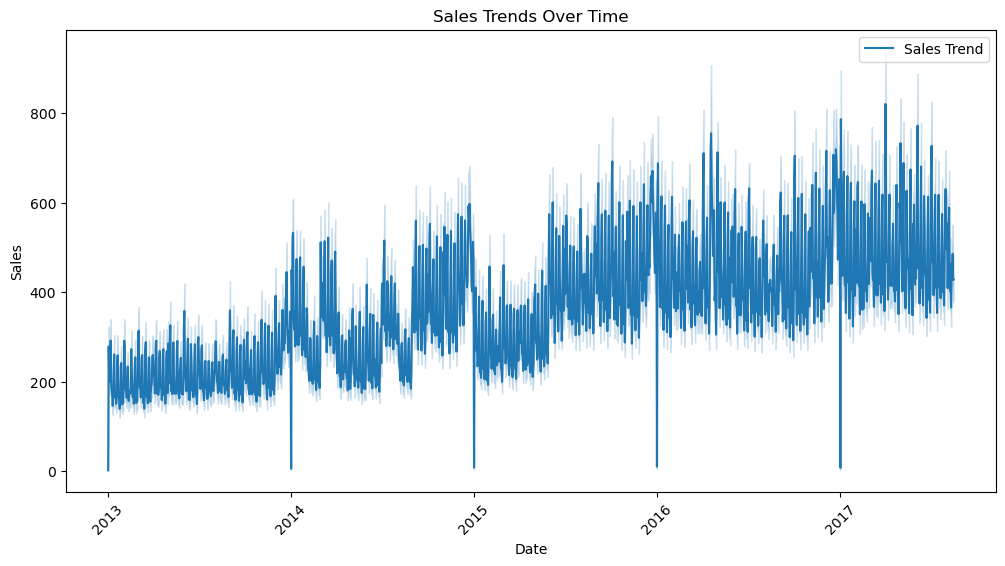

In [23]:
plt.figure(figsize=(12, 6))
sns.lineplot(x='date', y='sales', data=train, label='Sales Trend')

plt.title('Sales Trends Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.xticks(rotation=45)
plt.legend()
plt.show()

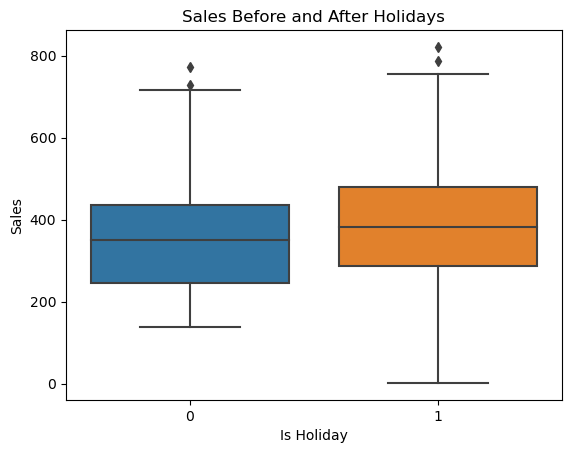

In [24]:
# Analyze Pre/Post-Holiday and Promotion Sales
holiday_sales = train.groupby(['date', 'is_holiday'])['sales'].mean().reset_index()
sns.boxplot(x='is_holiday', y='sales', data=holiday_sales)
plt.title('Sales Before and After Holidays')
plt.xlabel('Is Holiday')
plt.ylabel('Sales')
plt.show()

Correlation between Sales and Oil Prices:
               sales  dcoilwtico
sales       1.000000   -0.079009
dcoilwtico -0.079009    1.000000


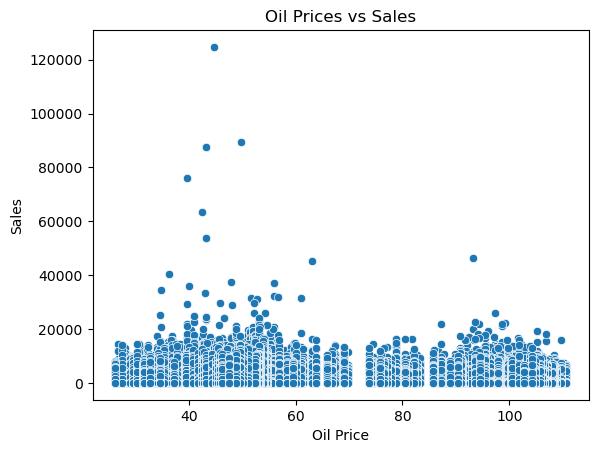

In [25]:
# Check Correlations Between Oil Prices & Sales
correlation = train[['sales', 'dcoilwtico']].corr()
print("Correlation between Sales and Oil Prices:")
print(correlation)
sns.scatterplot(x='dcoilwtico', y='sales', data=train)
plt.title('Oil Prices vs Sales')
plt.xlabel('Oil Price')
plt.ylabel('Sales')
plt.show()

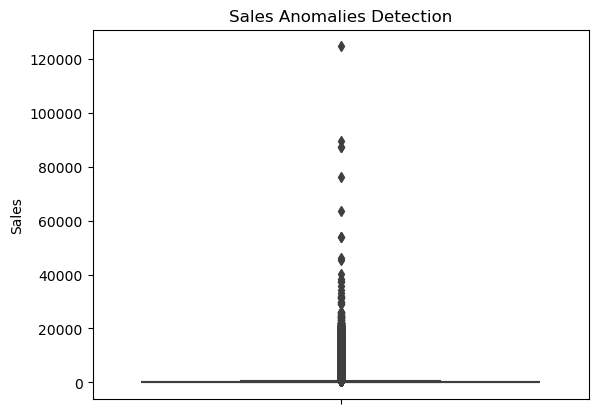

In [26]:
# Detect Anomalies in Sales Trends
sns.boxplot(y='sales', data=train)
plt.title('Sales Anomalies Detection')
plt.ylabel('Sales')
plt.show()

In [27]:
# Save processed dataset
train.to_csv('processed_train.csv', index=False)

print("Data processing and feature engineering completed.")

OSError: [Errno 28] No space left on device